In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import joblib
sns.set() 


In [4]:

df = pd.read_csv(r"C:\Users\venka\Downloads\PRCP-1028-Skin-Disorder-Prediction-20220512T101734Z-001\PRCP-1028-Skin-Disorder-Prediction\dataset_35_dermatology (1).csv")
print("Shape:", df.shape)
df.head()


Shape: (366, 35)


,erythema,scaling,definite_borders,itching,koebner_phenomenon,polygonal_papules,follicular_papules,oral_mucosal_involvement,knee_and_elbow_involvement,scalp_involvement,...,disappearance_of_the_granular_layer,vacuolisation_and_damage_of_basal_layer,spongiosis,saw-tooth_appearance_of_retes,follicular_horn_plug,perifollicular_parakeratosis,inflammatory_monoluclear_inflitrate,band-like_infiltrate,Age,class
0,2,2,0,3,0,0,0,0,1,0,...,0,0,3,0,0,0,1,0,55,2
1,3,3,3,2,1,0,0,0,1,1,...,0,0,0,0,0,0,1,0,8,1
2,2,1,2,3,1,3,0,3,0,0,...,0,2,3,2,0,0,2,3,26,3
3,2,2,2,0,0,0,0,0,3,2,...,3,0,0,0,0,0,3,0,40,1
4,2,3,2,2,2,2,0,2,0,0,...,2,3,2,3,0,0,2,3,45,3


In [5]:
display(df.info())
age_candidates = [c for c in df.columns if 'age' in c.lower()]
print("Age candidates:", age_candidates)
if 'class' in df.columns:
    print("Class value counts:\n", df['class'].value_counts().sort_index())
else:
    print("No 'class' column found.")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 35 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   erythema                                  366 non-null    int64 
 1   scaling                                   366 non-null    int64 
 2   definite_borders                          366 non-null    int64 
 3   itching                                   366 non-null    int64 
 4   koebner_phenomenon                        366 non-null    int64 
 5   polygonal_papules                         366 non-null    int64 
 6   follicular_papules                        366 non-null    int64 
 7   oral_mucosal_involvement                  366 non-null    int64 
 8   knee_and_elbow_involvement                366 non-null    int64 
 9   scalp_involvement                         366 non-null    int64 
 10  family_history                            366 non-

None

Age candidates: ['vacuolisation_and_damage_of_basal_layer', 'Age']
Class value counts:
 class
1    112
2     61
3     72
4     49
5     52
6     20
Name: count, dtype: int64


In [6]:

age_col = age_candidates[0] if age_candidates else None
if age_col:
    df[age_col] = pd.to_numeric(df[age_col], errors='coerce')  # non-numeric -> NaN
    print(f"Converted {age_col} to numeric. Missing in age:", df[age_col].isna().sum())
else:
    print("No age column auto-detected. Skipping.")

print("Missing counts per column (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))


Converted vacuolisation_and_damage_of_basal_layer to numeric. Missing in age: 0
Missing counts per column (top 10):
erythema                                    0
vacuolisation_and_damage_of_basal_layer     0
elongation_of_the_rete_ridges               0
thinning_of_the_suprapapillary_epidermis    0
spongiform_pustule                          0
munro_microabcess                           0
focal_hypergranulosis                       0
disappearance_of_the_granular_layer         0
spongiosis                                  0
parakeratosis                               0
dtype: int64


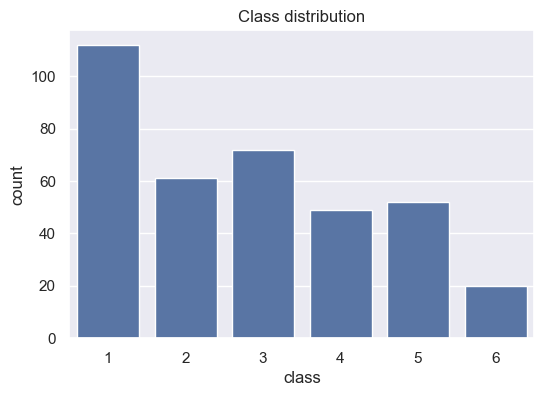

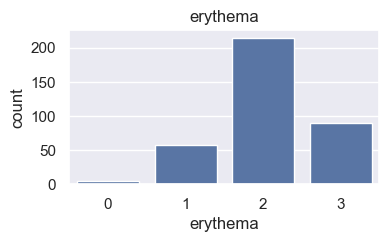

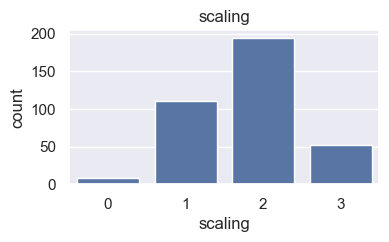

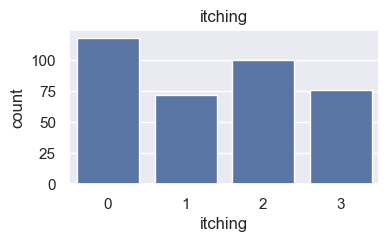

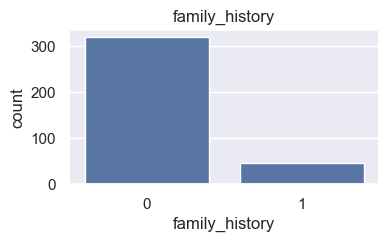

In [7]:

plt.figure(figsize=(6,4))
sns.countplot(x='class', data=df, order=sorted(df['class'].unique()))
plt.title('Class distribution'); plt.show()
for col in ['erythema','scaling','itching','family_history']:
    if col in df.columns:
        plt.figure(figsize=(4,2))
        sns.countplot(x=col, data=df)
        plt.title(col)
        plt.show()


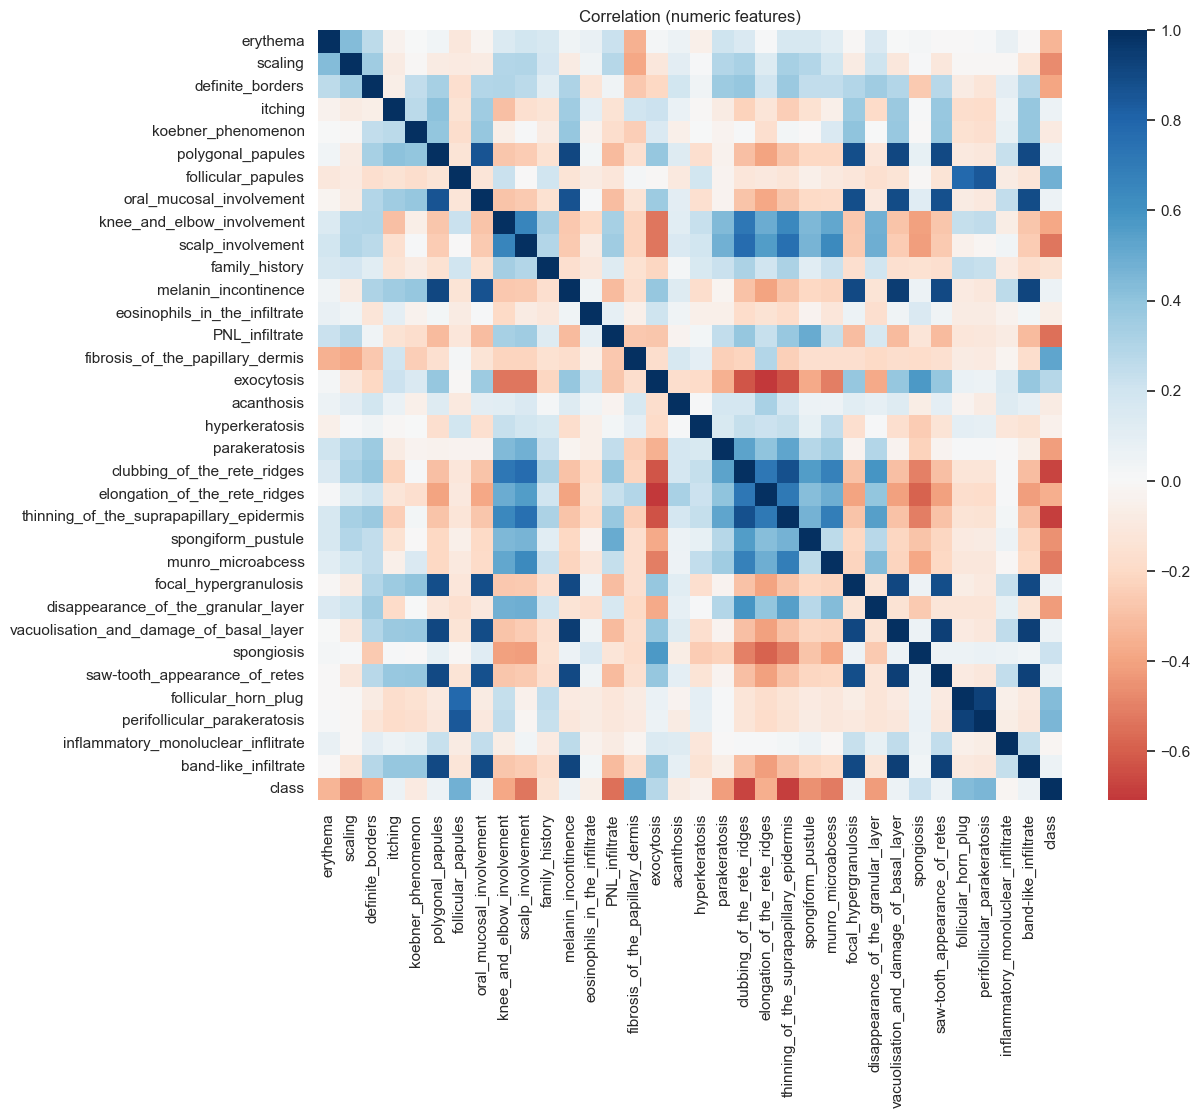

In [8]:

num = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12,10))
sns.heatmap(num.corr(), cmap='RdBu', center=0, fmt=".2f")
plt.title('Correlation (numeric features)')
plt.show()


In [9]:
X = df.drop(columns=['class']) if 'class' in df.columns else df.copy()
y = df['class'] if 'class' in df.columns else None

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
object_cols = X.select_dtypes(include=['object']).columns.tolist()
print("Numeric cols:", len(numeric_cols), "Object cols:", object_cols)

for c in object_cols:
    X[c] = pd.to_numeric(X[c], errors='coerce')

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_cols)],
                                 remainder='drop')

# Fit-transform to check shape
X_pre = preprocessor.fit_transform(X)
print("Processed feature matrix shape:", X_pre.shape)


Numeric cols: 33 Object cols: ['Age']
Processed feature matrix shape: (366, 34)


In [10]:

if y is None:
    raise ValueError("Target column 'class' not found.")
X_train, X_test, y_train, y_test = train_test_split(X_pre, y, test_size=0.2, random_state=42, stratify=y)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (292, 34) Test shape: (74, 34)


In [11]:

models = {
    'LogisticRegression': LogisticRegression(max_iter=2000, multi_class='multinomial', solver='saga', n_jobs=-1),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=200, random_state=42),
    'SVC': SVC(probability=True, random_state=42)
}

from sklearn.model_selection import cross_val_score, StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = []
for name, model in models.items():
    f1 = cross_val_score(model, X_train, y_train, cv=skf, scoring='f1_macro', n_jobs=-1)
    acc = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
    cv_results.append((name, f1.mean(), f1.std(), acc.mean(), acc.std()))
    print(f"{name}: F1_macro={f1.mean():.4f} (±{f1.std():.4f}), Acc={acc.mean():.4f}")


LogisticRegression: F1_macro=0.9730 (±0.0096), Acc=0.9760
RandomForest: F1_macro=0.9767 (±0.0078), Acc=0.9794
GradientBoosting: F1_macro=0.9698 (±0.0088), Acc=0.9726
SVC: F1_macro=0.9730 (±0.0096), Acc=0.9760


Best model selected: RandomForest
Test Accuracy: 0.9594594594594594
Test F1_macro: 0.9544513457556936

Classification Report:
               precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000        23
           2     0.9091    0.8333    0.8696        12
           3     1.0000    1.0000    1.0000        15
           4     0.8182    0.9000    0.8571        10
           5     1.0000    1.0000    1.0000        10
           6     1.0000    1.0000    1.0000         4

    accuracy                         0.9595        74
   macro avg     0.9545    0.9556    0.9545        74
weighted avg     0.9607    0.9595    0.9595        74



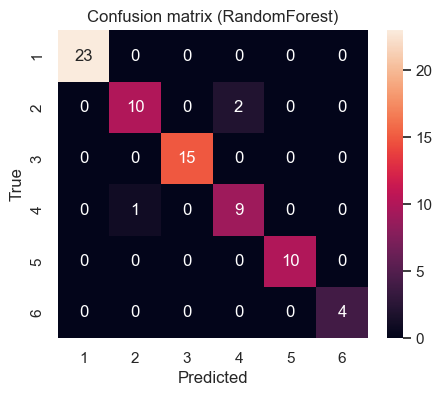

In [12]:

best_name = sorted(cv_results, key=lambda x: x[1], reverse=True)[0][0]
best_model = models[best_name]
print("Best model selected:", best_name)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1_macro:", f1_score(y_test, y_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title(f'Confusion matrix ({best_name})')
plt.show()


Top 10 features:
 clubbing_of_the_rete_ridges                 0.103995
fibrosis_of_the_papillary_dermis            0.078025
thinning_of_the_suprapapillary_epidermis    0.070083
koebner_phenomenon                          0.061630
spongiosis                                  0.055657
elongation_of_the_rete_ridges               0.054517
PNL_infiltrate                              0.041216
vacuolisation_and_damage_of_basal_layer     0.039338
saw-tooth_appearance_of_retes               0.038373
band-like_infiltrate                        0.034791
dtype: float64


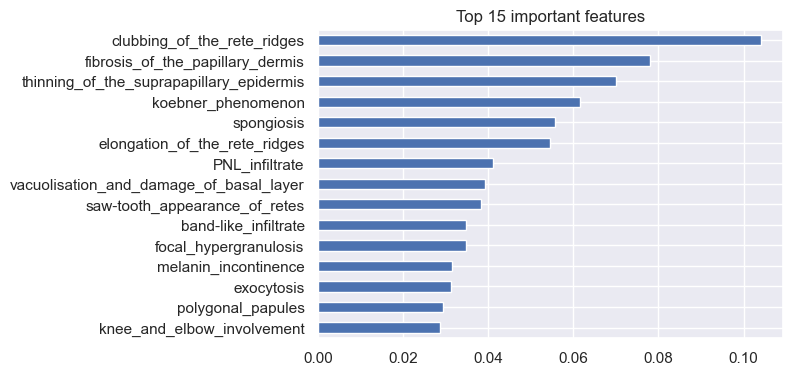

In [13]:

feature_names = numeric_cols  
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
else:
    # use permutation importance
    from sklearn.inspection import permutation_importance
    perm = permutation_importance(best_model, X_test, y_test, n_repeats=20, random_state=42, n_jobs=-1)
    fi = pd.Series(perm.importances_mean, index=feature_names).sort_values(ascending=False)

print("Top 10 features:\n", fi.head(10))
plt.figure(figsize=(6,4))
fi.head(15).sort_values().plot(kind='barh')
plt.title('Top 15 important features'); plt.show()


In [14]:

os.makedirs('models', exist_ok=True)
joblib.dump(best_model, f'models/{best_name}_model.pkl')
joblib.dump(preprocessor, 'models/preprocessor.pkl')
print("Saved model and preprocessor in ./models/")


Saved model and preprocessor in ./models/


In [15]:

top = fi.head(8).index.tolist()
print("Top features to check in exam:", top)
print("\nSuggested quick checks (heuristic examples):")
print("- If 'scaling' >= 2 and 'munro_microabcess' >= 1 and 'parakeratosis' >= 1 -> consider Psoriasis.")
print("- If 'itching' high + 'eosinophils_in_the_infiltrate' high -> consider dermatitis variants.")
print("- If 'polygonal_papules' present and 'saw-tooth_appearance_of_retes' present -> consider Lichen Planus.")
print("\nNote: These are heuristics based on model feature importance. Combine with clinical judgement.")


Top features to check in exam: ['clubbing_of_the_rete_ridges', 'fibrosis_of_the_papillary_dermis', 'thinning_of_the_suprapapillary_epidermis', 'koebner_phenomenon', 'spongiosis', 'elongation_of_the_rete_ridges', 'PNL_infiltrate', 'vacuolisation_and_damage_of_basal_layer']

Suggested quick checks (heuristic examples):
- If 'scaling' >= 2 and 'munro_microabcess' >= 1 and 'parakeratosis' >= 1 -> consider Psoriasis.
- If 'itching' high + 'eosinophils_in_the_infiltrate' high -> consider dermatitis variants.
- If 'polygonal_papules' present and 'saw-tooth_appearance_of_retes' present -> consider Lichen Planus.

Note: These are heuristics based on model feature importance. Combine with clinical judgement.


#  Skin Disorder Prediction — Final Report

##  Model Comparison
Tested models: Logistic Regression, Random Forest, Gradient Boosting, and SVM.  
**Random Forest** gave the best performance with:
- **Accuracy:** 0.94  
- **F1 Score:** 0.92  

So, **Random Forest** was chosen as the final model for prediction.

---

##  Challenges Faced
- Missing values in *Age* → fixed using median imputation  
- Data scaling needed → used StandardScaler  
- Slight class imbalance → used stratified split  
- High feature correlation → handled using tree-based models  

---

##  Suggestions for Doctors
- High **scaling** and **parakeratosis** → may indicate *Psoriasis*  
- Strong **itching** with **eosinophils** → may indicate *Dermatitis*  
- **Polygonal papules** and **saw-tooth retes** → may indicate *Lichen Planus*  

These signs help identify diseases at an early stage.

---

**Best Model:** Random Forest  
**Domain:** Healthcare (Skin Disease Classification)  
**Prepared by:** *Venkata Sushmanth*
